## Importing Required Dependencies

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
%matplotlib inline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split

## Dataset Preparation

###  Load and Prepare Data

In [4]:
my_df=pd.read_csv('./data.csv')

In [5]:
X = my_df.drop(columns=['label']).values
y = my_df['label'].values

### One-Hot Encoding

In [6]:
y=np.array(pd.get_dummies(y,dtype=int))

### SMOTE for Balanced Sampling

In [7]:
# Assuming X and y are your features and target labels

# Drop rows with NaN values before applying SMOTE
my_df_cleaned = my_df.dropna()
X = my_df_cleaned.drop(columns=['label']).values
y = my_df_cleaned['label'].values
y=np.array(pd.get_dummies(y,dtype=int))


smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert one-hot encoded labels back to class labels
y_resampled_labels = np.argmax(y_resampled, axis=1)

# Check the distribution of data after resampling
counter = Counter(y_resampled_labels)
print("Class distribution after resampling:\n", counter)

Class distribution after resampling:
 Counter({np.int64(3): 1355, np.int64(2): 1355, np.int64(1): 1355, np.int64(0): 1355, np.int64(9): 1355, np.int64(6): 1355, np.int64(8): 1355, np.int64(5): 1355, np.int64(7): 1355, np.int64(4): 1355})


### Data Split

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled, y_resampled,test_size=0.2,random_state=0)

### Scaling

In [9]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'standard_scaler_cnn_1d.pkl')

['standard_scaler_cnn_1d.pkl']

In [10]:
num_labels=10

## Hyperparameter Tuning

### Function build_model


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [12]:
def build_cnn_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh']),
        input_shape=(X_train.shape[1], 1)
    ))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size_1', values=[2, 3])))

    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation=hp.Choice('activation_2', values=['relu', 'tanh'])
    ))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size_2', values=[2, 3])))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=64),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                     hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [13]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

import keras_tuner as kt

# List of possible epochs to try
possible_epochs = [50, 100]

# Loop through each epoch count in the list
for epoch_count in possible_epochs:
    # Initialize the tuner with the CNN model
    tuner = kt.RandomSearch(
        build_cnn_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='cnn_tuner_dir',
        project_name=f'cnn_audio_classification_{epoch_count}'
    )

    # Perform the search with the current epoch count
    tuner.search(X_train, y_train,
                 epochs=epoch_count,
                 validation_split=0.2,
                 callbacks=[early_stopping])
    # Retrieve the best hyperparameters

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters for {epoch_count} epochs: {best_hps.values}")

Trial 10 Complete [00h 03m 40s]
val_accuracy: 0.9677121639251709

Best val_accuracy So Far: 0.9787822961807251
Total elapsed time: 00h 19m 35s
Best hyperparameters for 100 epochs: {'filters_1': 128, 'kernel_size_1': 5, 'activation_1': 'tanh', 'pool_size_1': 3, 'filters_2': 192, 'kernel_size_2': 5, 'activation_2': 'tanh', 'pool_size_2': 3, 'units': 384, 'activation_dense': 'relu', 'dropout': 0.30000000000000004, 'learning_rate': 0.0001}


In [14]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
best_model.save('best_cnn_1d_model.keras')

### Best Model Test

In [16]:
test_accuracy=best_model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9797047972679138


### Best hyperparameters

In [17]:
import pandas as pd
import keras_tuner as kt

# Initialize a list to hold dictionaries of hyperparameters for each epoch count
hyperparameters_list = []

# List of possible epochs you want to analyze
possible_epochs = [50, 100]

for epoch_count in possible_epochs:
    # Initialize the tuner with the CNN model
    tuner = kt.RandomSearch(
        build_cnn_model,  # Ensure you use your existing function for model building
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='cnn_tuner_dir',
        project_name=f'cnn_audio_classification_{epoch_count}'
    )

    # Get best hyperparameters for the current epoch count
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0].values

    # Add the epoch count to the dictionary of hyperparameters
    hyperparameters = {"epoch_count": epoch_count, **best_hyperparameters}

    # Append the dictionary to the list
    hyperparameters_list.append(hyperparameters)

# Create a DataFrame from the list of hyperparameter dictionaries
best_params_df = pd.DataFrame(hyperparameters_list)


Reloading Tuner from cnn_tuner_dir/cnn_audio_classification_50/tuner0.json
Reloading Tuner from cnn_tuner_dir/cnn_audio_classification_100/tuner0.json


In [18]:
best_params_df

,epoch_count,filters_1,kernel_size_1,activation_1,pool_size_1,filters_2,kernel_size_2,activation_2,pool_size_2,units,activation_dense,dropout,learning_rate
0,50,128,3,relu,3,128,3,relu,2,256,tanh,0.3,0.0010
1,100,128,5,tanh,3,192,5,tanh,3,384,relu,0.3,0.0001


In [19]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for hp_name, hp_value in best_hyperparameters.values.items():
    print(f"{hp_name}: {hp_value}")

Best Hyperparameters:
filters_1: 128
kernel_size_1: 5
activation_1: tanh
pool_size_1: 3
filters_2: 192
kernel_size_2: 5
activation_2: tanh
pool_size_2: 3
units: 384
activation_dense: relu
dropout: 0.30000000000000004
learning_rate: 0.0001


In [20]:
import pandas as pd

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Convert hyperparameters to a pandas DataFrame
hyperparameters_df = pd.DataFrame(list(best_hyperparameters.values.items()), columns=["Hyperparameter", "Value"])

In [21]:
hyperparameters_df

,Hyperparameter,Value
0,filters_1,128
1,kernel_size_1,5
2,activation_1,tanh
3,pool_size_1,3
4,filters_2,192
5,kernel_size_2,5
6,activation_2,tanh
7,pool_size_2,3
8,units,384
9,activation_dense,relu


## Train the Best Model again

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4128 - loss: 1.7822 - val_accuracy: 0.6522 - val_loss: 1.0432
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6527 - loss: 1.0160 - val_accuracy: 0.7371 - val_loss: 0.8221
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7310 - loss: 0.8139 - val_accuracy: 0.7620 - val_loss: 0.7069
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7663 - loss: 0.7005 - val_accuracy: 0.7777 - val_loss: 0.6133
Epoch 5/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7860 - loss: 0.6328 - val_accuracy: 0.8233 - val_loss: 0.5224
Epoch 6/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8128 - loss: 0.5535 - val_accuracy: 0.8501 - val_loss: 0.4864
Epoch 7/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8448 - loss: 0.4954 - val_accuracy: 0.8819 - val_loss: 0.4269
Epoch 8/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8520 - loss: 0.4507 - val_accuracy: 0.8893

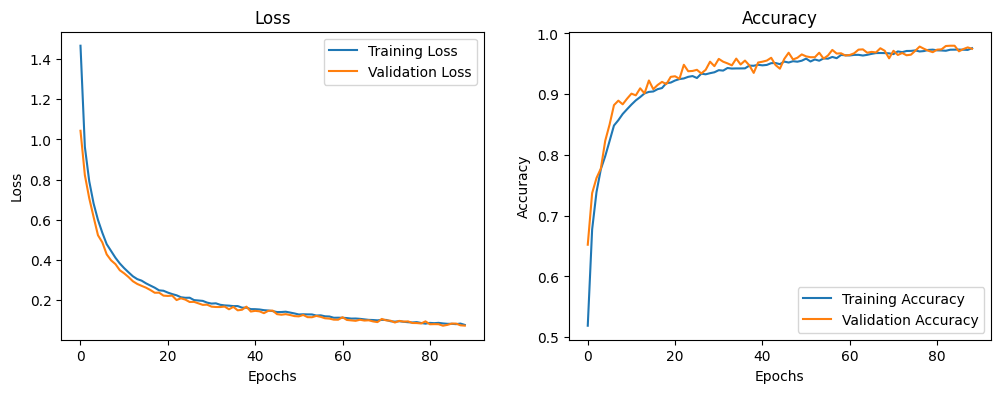

In [22]:
# Rebuild the best model using the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

model = build_cnn_model(best_hyperparameters)

# Train the model again, this time keeping track of the history for plotting
history = model.fit(
    X_train, y_train,
    epochs=100,  # You can set an appropriate number of epochs here
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 4))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9756457805633545


In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 124, 128)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 41, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 37, 192)        │       123,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 12, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         3,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,038,432 (11.59 MB)

 Trainable params: 1,012,810 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,025,622 (7.73 MB)

## Classfication Report

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Example of class names
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# Generate predictions for the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Get the class labels from the one-hot encoded predictions and true values
y_pred_classes = np.argmax(y_pred, axis=-1)
y_test_classes = np.argmax(y_test, axis=-1)

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.80      0.99      0.88       270
        car_horn       1.00      1.00      1.00       268
children_playing       0.95      0.95      0.95       285
        dog_bark       1.00      0.92      0.96       274
        drilling       0.98      0.95      0.97       241
   engine_idling       0.99      1.00      1.00       253
        gun_shot       1.00      1.00      1.00       286
      jackhammer       1.00      1.00      1.00       269
           siren       0.99      0.91      0.95       294
    street_music       0.99      0.93      0.96       270

        accuracy                           0.97      2710
       macro avg       0.97      0.97      0.97      2710
    weighted avg       0.97      0.97      0.97      2710



## Confution Matrix

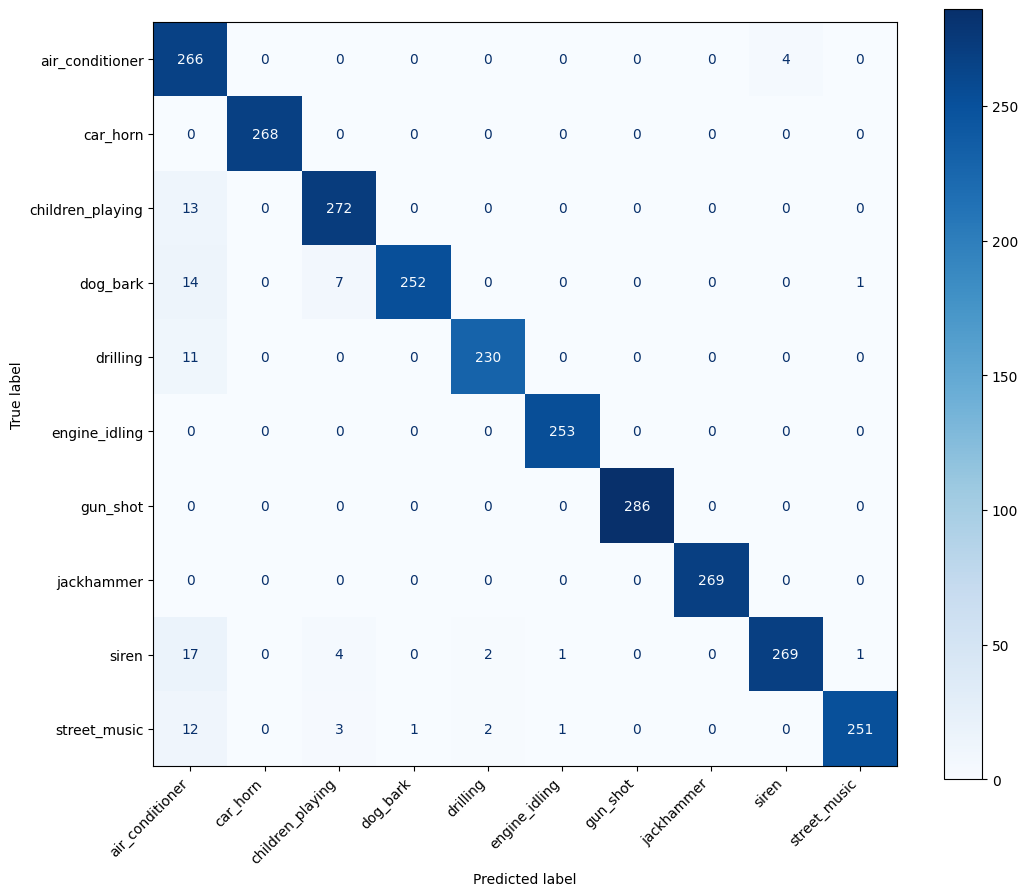

In [26]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))  # Specify figure size directly in subplots

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass the axis to the plot method

ax.set_xticklabels(disp.display_labels, rotation=45, ha='right')  # Rotate class names on x-axis for better readability

plt.show()